## Install all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# set random state for numpy
np.random.seed(42)

In [3]:
# WandB for experiment tracking
import wandb
from wandb.keras import WandbCallback

# initialization of your project
wandb.init(anonymous='allow', project="potato-diesease-classification", name="basic-convnet")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hemantai. Use `wandb login --relogin` to force relogin


In [4]:
# check gpu is running properly
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


In [5]:
# set all the constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [6]:
# import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
)


Found 2152 files belonging to 3 classes.


In [7]:
# find the class names in our dataset
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
# check the shape of the batch
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 2, 0, 0])>>


## Visualize some of the images from our dataset

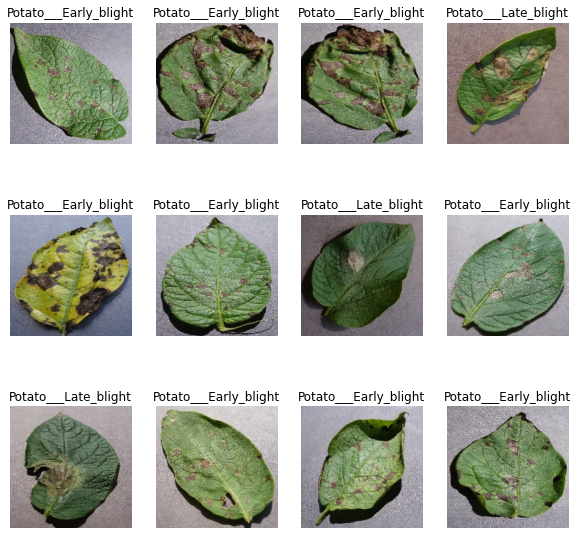

In [9]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## split the dataset
split the data set in train, validation and test dataset. we have 64 total no. of batches in out dataset. so we take 80% batches for our training set, 20% for testing and finally 10% for validation from testing dataset.

In [10]:
# length of the dataset
print(f"lenght of the dataset: {len(dataset)}")

# taining dataset, take 80% data from original dataset which is almost 54 batches
train_ds = dataset.take(54)
print(f"lenght of the training set: {len(train_ds)}")

# total remaining data for test set
test_ds = dataset.skip(54)
print(f"lenght of the test set: {len(test_ds)}")

# 10% data for validation from test set which is almost 68*0.1 = 6 batches
val_ds = test_ds.take(6)
print(f"lenght of the validation set: {len(val_ds)}")

# after validation update remaining data for testing
test_ds = test_ds.skip(6)
print(f"lenght of the test set: {len(test_ds)}")

lenght of the dataset: 68
lenght of the training set: 54
lenght of the test set: 14
lenght of the validation set: 6
lenght of the test set: 8


In [11]:
# create the function to shuffle the dataset
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [13]:
print(f"lenght of the training set: {len(train_ds)}")
print(f"lenght of the validation set: {len(val_ds)}")
print(f"lenght of the test set: {len(test_ds)}")

lenght of the training set: 54
lenght of the validation set: 6
lenght of the test set: 8


## Cache, Shuffle, and Prefetch the Dataset

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [15]:
# create a layer for resizing and normalization
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [16]:
# perform some data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
# applying data augmentation to train dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


## Model Architecture

In [18]:
# run experiment tracking
wandb.init(anonymous='allow', project="potato-diesease-classification", name= "convnet architecture")

In [20]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size= (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

## Compiling the Model

In [22]:
# use adam as optimizer, SparseCategoricalCrossentropy for losses 
# accuracy as a metric 
model.compile(optimizer='adam',
            loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

In [24]:
%%wandb
history = model.fit(
    train_ds,
    batch_size= BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[WandbCallback()]

)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Consider rewriting this model with the Functional API.


wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/50
54/54 [==============================] - 21s 267ms/step - loss: 0.8973 - accuracy: 0.5156 - val_loss: 0.8419 - val_accuracy: 0.6302
Epoch 2/50
54/54 [==============================] - 13s 248ms/step - loss: 0.7249 - accuracy: 0.6719 - val_loss: 0.6389 - val_accuracy: 0.7031
Epoch 3/50
54/54 [==============================] - 13s 246ms/step - loss: 0.4561 - accuracy: 0.8021 - val_loss: 0.3746 - val_accuracy: 0.7969
Epoch 4/50
54/54 [==============================] - 13s 247ms/step - loss: 0.3343 - accuracy: 0.8738 - val_loss: 0.2732 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 13s 247ms/step - loss: 0.3043 - accuracy: 0.8785 - val_loss: 0.5566 - val_accuracy: 0.8125
Epoch 6/50
54/54 [==============================] - 13s 246ms/step - loss: 0.2584 - accuracy: 0.9034 - val_loss: 0.2032 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 13s 247ms/step - loss: 0.1690 - accuracy: 0.9306 - val_loss: 0.1590 - val_accuracy: 0.9427

In [25]:
# evaluate our model against the test data set
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 25ms/step - loss: 0.0491 - accuracy: 0.9883


In [26]:
# score is just a list containing loss and accuracy value
scores

[0.04914601147174835, 0.98828125]

## Plotting the Accuracy and Loss Curves

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', '_timestamp', '_runtime'])

In [32]:
# show loss for first 5 epochs 
history.history['loss'][:5]  # bcoz history keys are python list

[0.8973113298416138,
 0.7249467372894287,
 0.4560784697532654,
 0.33433249592781067,
 0.3043443262577057]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

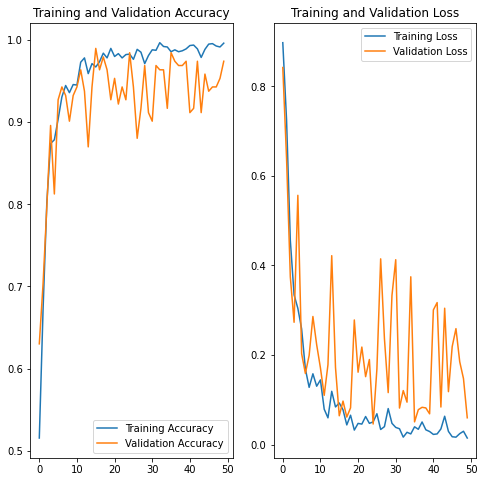

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Run prediction on a sample image


first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


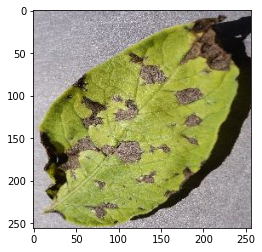

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])



## write a function for inference

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



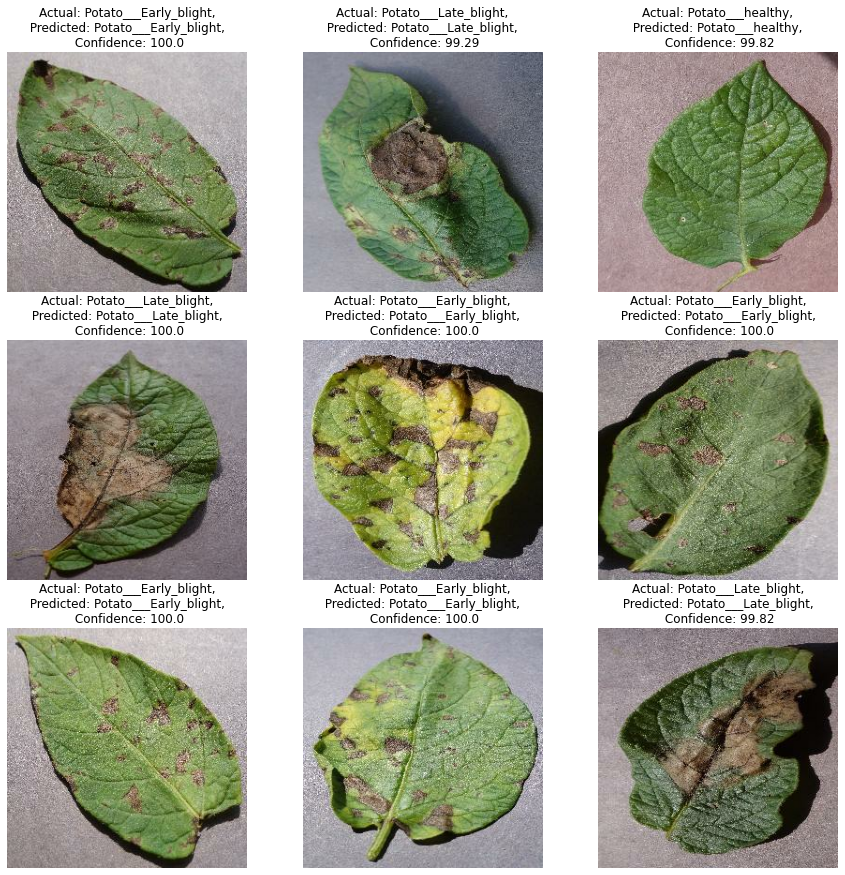

In [47]:
# now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}")

        plt.axis("off")

## Saving the Model

In [52]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


In [48]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [53]:
model.save("../potatoes.h5")